_____________________________________________________________________________
# LSTM Time Series Forecasting Practice for REU Position
_____________________________________________________________________________
## Reference: 
- ### Video: LSTM Time Series Forecasting Tutorial in Python
- ### Author: Greg Hogg
- ### Link: https://www.youtube.com/watch?v=c0k-YLQGKjY


_____________________________________________________________________________
### Import nessecary libraries for preprocessing
_____________________________________________________________________________

In [2]:
import tensorflow as tf # NN Library
import os # For working with dataset
import pandas as pd # Data management
import numpy as np # Lin Alg

# Ignore warnings from tensorflow. Although the warnings are informative, 
# they are irrelavant to this specific project, and no errors are present
# used for the sake of brevity and readability 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

_____________________________________________________________________________
### Get climate change dataset from tf's datasets through tf utils
_____________________________________________________________________________

In [2]:
# Provide path to one of tf's datasets
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

# Provide the CSV path, and get data
csv_path, _ = os.path.splitext(zip_path)

_____________________________________________________________________________
### Brief Examination of data
_____________________________________________________________________________

In [3]:
# Save data to DataFrame
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


_____________________________________________________________________________
### Switch index to be a time series index using pandas timeseries method
_____________________________________________________________________________

In [4]:
# Change index to datetime with our specific format
df.index = pd.to_datetime(df['Date Time'], format = '%d.%m.%Y %H:%M:%S')
df[:2]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


_____________________________________________________________________________
### We are just going to use degrees in celsius.
- #### We are basically going to use the hourly updates to predict tempurature by the hour
- #### Then we will predict hours at a time
- #### Our data will be similar to a 4D tensor
_____________________________________________________________________________

<AxesSubplot:xlabel='Date Time'>

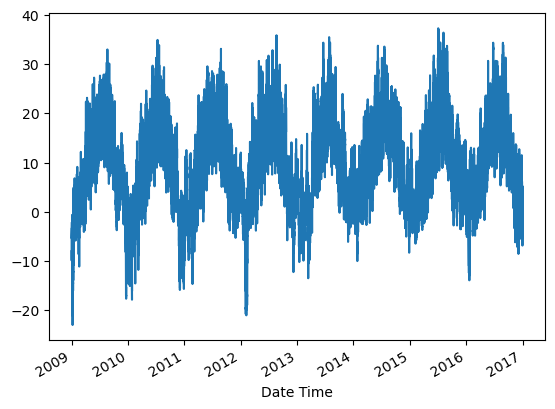

In [5]:
# Since we are using datetime as our index, we can simply plot the Celsius value to see general temp fluctuationd
temp = df["T (degC)"]
temp.plot()

_____________________________________________________________________________
### What we want our tensor to look like
- #### How to develop a forecasting problem to a supervised learning problem
_____________________________________________________________________________

In [6]:
#____________________________________________________________________________
### Feature Space  (Input)     |  ### Y Hat Vector (Output)
# [[[1], [2], [3], [4], [5]]]  |  [6]
# [[[2], [3], [4], [5], [6]]]  |  [7]
# [[[3], [4], [5], [6], [7]]]  |  [8]
### "Window size 
### (How many hours are we using)
#____________________________________________________________________________

In [7]:
def df_to_X_y(df, window_size = 5): # we decide the window size
    '''Get our tensor to a shape that works for supervised learning'''
    
    df_as_np = df.to_numpy() # we want a numpy matrix here for Lin Alg
    X = [] # we are going to build this up with the rows of temp values by hour
    y = [] # we are going to do the smae with the predictions
    
    for i in range(len(df_as_np) - window_size): # here we subtract window size to "stay within index"
        
        # wrap each of the rows in a list with list comprehension to get to format model accepts
        row = [[a] for a in df_as_np[i:i+5]] # Whatever i is, include the next 4, doesn't include the fifth
        
        # append formatted row to temp list
        X.append(row) 
        
        # True value for the input row
        label = df_as_np[i + 5] # This is the "fifth" temp that we want to predict
        y.append(label) # append label to temp list
    
    # return the tuple of the numpy arrays of the temp lists storing feature and label values
    return np.array(X), np.array(y)

In [8]:
# Set how many hours of temp we want to use, which is our "window"
WINDOW_SIZE = 5

# Call the function to transform the dataset into the format that our model is going to accpet
X, y = df_to_X_y(temp, WINDOW_SIZE)

# Check output shape as sanity check
X.shape, y.shape

((420546, 5, 1), (420546,))

In [9]:
# This is basically displaying the same thing as the comments explaining the intended format above
# But in a harder to interpret format
X

array([[[-8.02],
        [-8.41],
        [-8.51],
        [-8.31],
        [-8.27]],

       [[-8.41],
        [-8.51],
        [-8.31],
        [-8.27],
        [-8.05]],

       [[-8.51],
        [-8.31],
        [-8.27],
        [-8.05],
        [-7.62]],

       ...,

       [[-4.09],
        [-3.76],
        [-3.93],
        [-4.05],
        [-3.35]],

       [[-3.76],
        [-3.93],
        [-4.05],
        [-3.35],
        [-3.16]],

       [[-3.93],
        [-4.05],
        [-3.35],
        [-3.16],
        [-4.23]]])

_____________________________________________________________________________
### Train/ Validation/ Test split
_____________________________________________________________________________

In [10]:
# First 60,000 Datapoints for Train set
X_train, y_train = X[:60000], y[:60000]

# Next 5,000 Datapoints for Validation set
X_val, y_val = X[60000:65000], y[60000:65000]

# Give the rest to Test set
X_test, y_test = X[65000:], y[65000:]

# CHeck the shape as sanity check
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (355546, 5, 1), (355546,))

_____________________________________________________________________________
### Import nessecary libraries for Time series Forecasting
_____________________________________________________________________________

In [11]:
from tensorflow.keras.models import Sequential # Model initialization and format
from tensorflow.keras.layers import * # For setting up architecture
from tensorflow.keras.callbacks import ModelCheckpoint # For saving model that does best on val set
from tensorflow.keras.losses import MeanSquaredError # MSE works well for our loss function given the problem
from tensorflow.keras.metrics import RootMeanSquaredError # For extra evaluation
from tensorflow.keras.optimizers import Adam # Optimizer

_____________________________________________________________________________
### Initialize model
_____________________________________________________________________________

In [12]:
model = Sequential() # Use sequential API
model.add(InputLayer((5,1))) # Specifty the shape of the input layer (5 X 1 vectors)
model.add(LSTM(64)) # Initialize LSTM layer to pass to the RNN
model.add(Dense(8, 'relu')) # Pass that to 8 relu functions
model.add(Dense(1, 'linear')) # Since we have a single vector, linear output for our preditctions

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


_____________________________________________________________________________
### Specify training callbacks
_____________________________________________________________________________

In [13]:
cp = ModelCheckpoint('best_model', save_best_only = True) # Only save best model after each epoch

_____________________________________________________________________________
### Compile Model
_____________________________________________________________________________

In [14]:
# Compile model with nessecary paramters
model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.01), metrics = [RootMeanSquaredError()])

_____________________________________________________________________________
### Train Model
_____________________________________________________________________________

In [15]:
# provide train, val, and test data to train statement.
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, callbacks = cp)

Epoch 1/10
1863/1875 [============================>.] - ETA: 0s - loss: 0.7454 - root_mean_squared_error: 0.8634

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.7410 - root_mean_squared_error: 0.8608 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2584
Epoch 2/10
1856/1875 [============================>.] - ETA: 0s - loss: 0.0720 - root_mean_squared_error: 0.2683

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0719 - root_mean_squared_error: 0.2682 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2248
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0659 - root_mean_squared_error: 0.2567 - val_loss: 0.0561 - val_root_mean_squared_error: 0.2369
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0648 - root_mean_squared_error: 0.2547 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2560
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0611 - root_mean_squared_error: 0.2471 - val_loss: 0.0876 - val_root_mean_squared_error: 0.2959
Epoch 6/10
1862/1875 [============================>.] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.2418

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0579 - root_mean_squared_error: 0.2405 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2175
Epoch 8/10
1853/1875 [============================>.] - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.2395

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2200
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0555 - root_mean_squared_error: 0.2355 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2178


_____________________________________________________________________________
#### Performance getting better until the last epoch, with great performance for out-of-the-box solution to predicting tempuratures in a time-series using an LSTM
_____________________________________________________________________________

_____________________________________________________________________________
### Load best model and run a test with it
_____________________________________________________________________________

In [16]:
from tensorflow.keras.models import load_model
model_best = load_model('best_model')

_____________________________________________________________________________
 Make train test and validation, and run model again to show where the actual predictions are
_____________________________________________________________________________

In [17]:
# Make predictions
train_predictions = model_best.predict(X_train).flatten() # Without flatten, its that same double bracketed list

# Return results of best model as Dataframe
train_results = pd.DataFrame(data = {"Train Predictions": train_predictions, 'Actuals': y_train})
train_results

1875/1875 [==============================] - 2s 987us/step


,Train Predictions,Actuals
0,-8.244583,-8.05
1,-7.900054,-7.62
2,-7.385185,-7.62
3,-7.578332,-7.91
4,-7.978569,-8.43
...,...,...
59995,1.638692,1.82
59996,1.804174,1.88
59997,1.863881,1.74
59998,1.557280,1.64


In [18]:
# Calculate and display RMSE for best model
mse_loss = tf.keras.losses.MeanSquaredError()
mse_score = mse_loss(y_train, train_predictions) # MSE scores
rmse_score = tf.sqrt(mse_score) # RMSE Scores
print(f"RMSE: {rmse_score}")

RMSE: 0.2047765552997589


_____________________________________________________________________________
### Visualize the RMSE of the best performing model
_____________________________________________________________________________

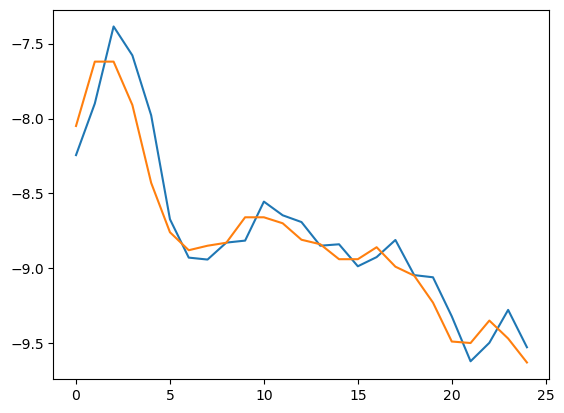

In [22]:
import matplotlib.pyplot as plt

# Visualize the RMSE for the first 25 examples from the test set
plt.plot(train_results["Train Predictions"][:25])
plt.plot(train_results["Actuals"][:25])

_____________________________________________________________________________
We can see that the model is doing fairly well, with a RMSE of .204 for our best performer. With some tweaks, we could easily implement some kind of LSTM like this in the REU I will be engaged in over the summer.
_____________________________________________________________________________

_____________________________________________________________________________
## Overall, this was a really great learning experience to get some hands-on with LSTM's. I am still a bit shakey on the mathematics going on under the hood of the model, but seeing how the input tensor needs to be shaped, and generally how to use an LSTM for temperature predcictions in a time-series, is going to be great experience for my summer research position
_____________________________________________________________________________